# Objective:
# Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

In [1]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import seaborn as sns


# 1. Read the dataset


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
project_path = '/content/drive/My Drive/Colab Notebooks/'

In [5]:
dataset_file = project_path + 'bank.csv'

In [6]:
data = pd.read_csv(dataset_file)

In [7]:
data.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
data.shape

(10000, 14)

In [9]:
df=data.copy()

In [10]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [11]:
for i in df.columns[df.dtypes=='object']:
    df[i]=df[i].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   RowNumber        10000 non-null  int64   
 1   CustomerId       10000 non-null  int64   
 2   Surname          10000 non-null  category
 3   CreditScore      10000 non-null  int64   
 4   Geography        10000 non-null  category
 5   Gender           10000 non-null  category
 6   Age              10000 non-null  int64   
 7   Tenure           10000 non-null  int64   
 8   Balance          10000 non-null  float64 
 9   NumOfProducts    10000 non-null  int64   
 10  HasCrCard        10000 non-null  int64   
 11  IsActiveMember   10000 non-null  int64   
 12  EstimatedSalary  10000 non-null  float64 
 13  Exited           10000 non-null  int64   
dtypes: category(3), float64(2), int64(9)
memory usage: 1001.7 KB


convert object variables to category 


# 2. Drop the columns which are unique for all users like IDs (5 points)


In [12]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

the first 2 variables are unique for all users, also we drop Surname columns since is irrelevent column.

In [13]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis = 1)

In [14]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

# 3. Perform bivariate analysis and give your insights from the same (5 points) 


In [15]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [16]:
#Check if there is duplicate in the data
duplicate = df[df.duplicated()] 
duplicate

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


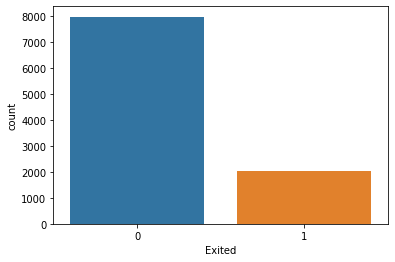

In [18]:
sns.countplot(df['Exited'])

The avrage age of the data is 39, and data is very skewed in terms of exited customers, 

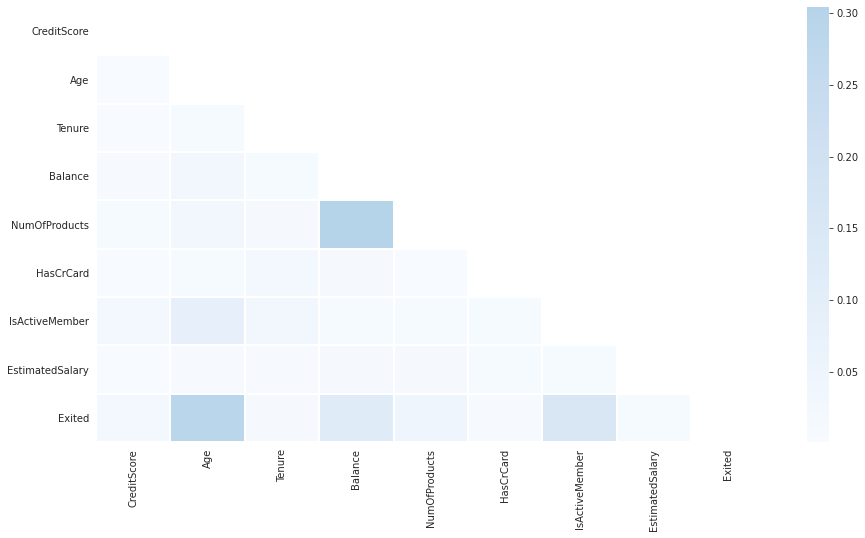

In [19]:
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= False, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= True, linewidths= 1, mask = mask)   # Da Heatmap
plt.xticks(rotation = 90)   # Aesthetic purposes
plt.yticks(rotation = 0)   # Aesthetic purposes
plt.show()


In [20]:
# Let us see the significant correlation either negative or positive among independent attributes..
c = df.corr().abs() # Since there may be positive as well as -ve correlation
s = c.unstack() # 
so = s.sort_values(ascending=False) # Sorting according to the correlation
so=so[(so<1) & (so>0.3)].drop_duplicates().to_frame() # Due to symmetry.. dropping duplicate entries.
so.columns = ['correlation']
so.head(10)

,,correlation
NumOfProducts,Balance,0.30418


not strong correlation can be seen in the data

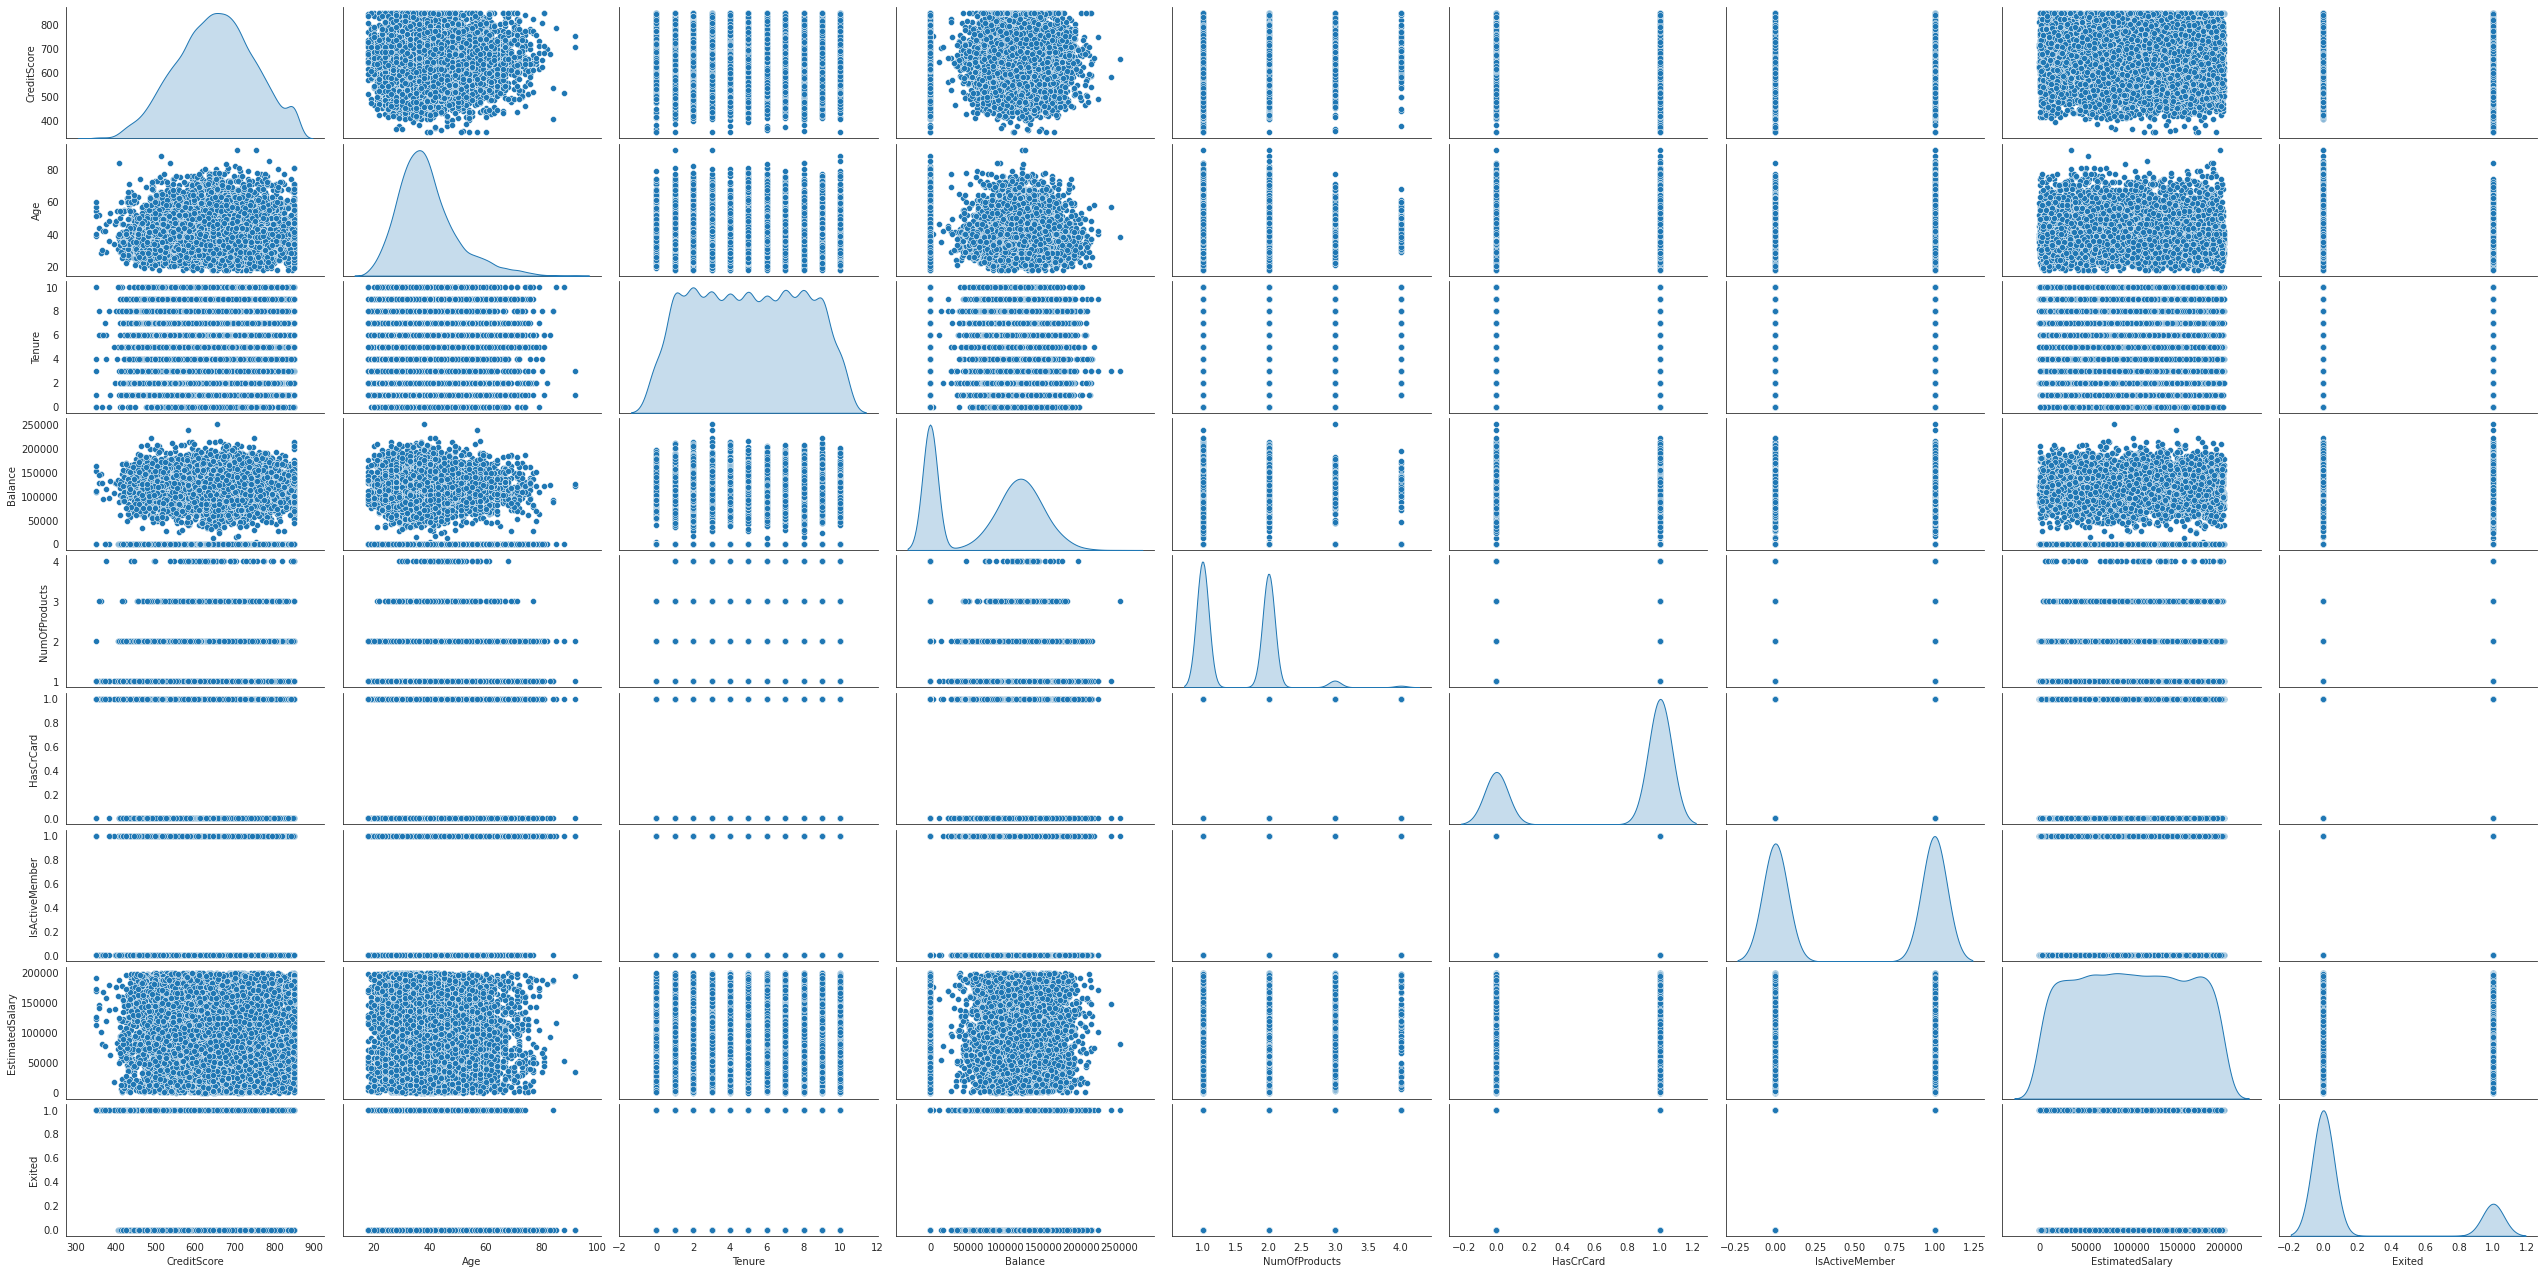

In [21]:
sns.pairplot(df,height=2,aspect=2 , diag_kind='kde')

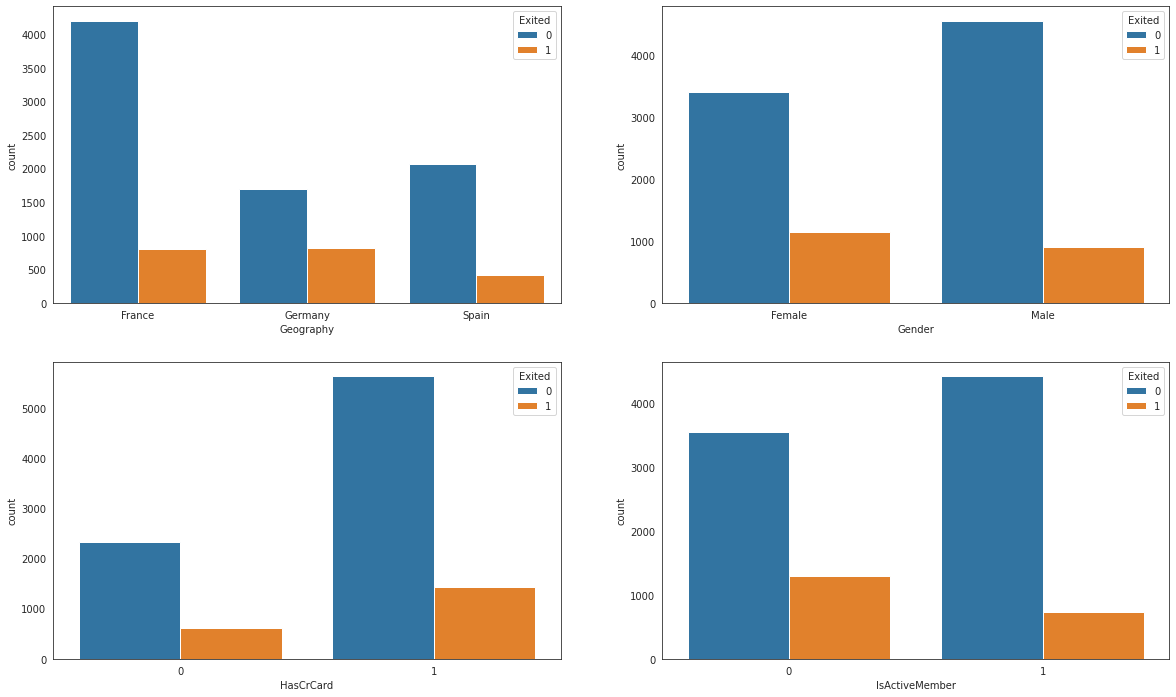

In [22]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

Here w ecan see forexample most of the customers are from France or Male . but these two factors doesn't change exited status a lot. Female have higher churn rate. 
Also it looks customer who churned have credit card but in general most of customers have credit card and this not clear yet.
The one is intersting is that customers who exited are not active members. 

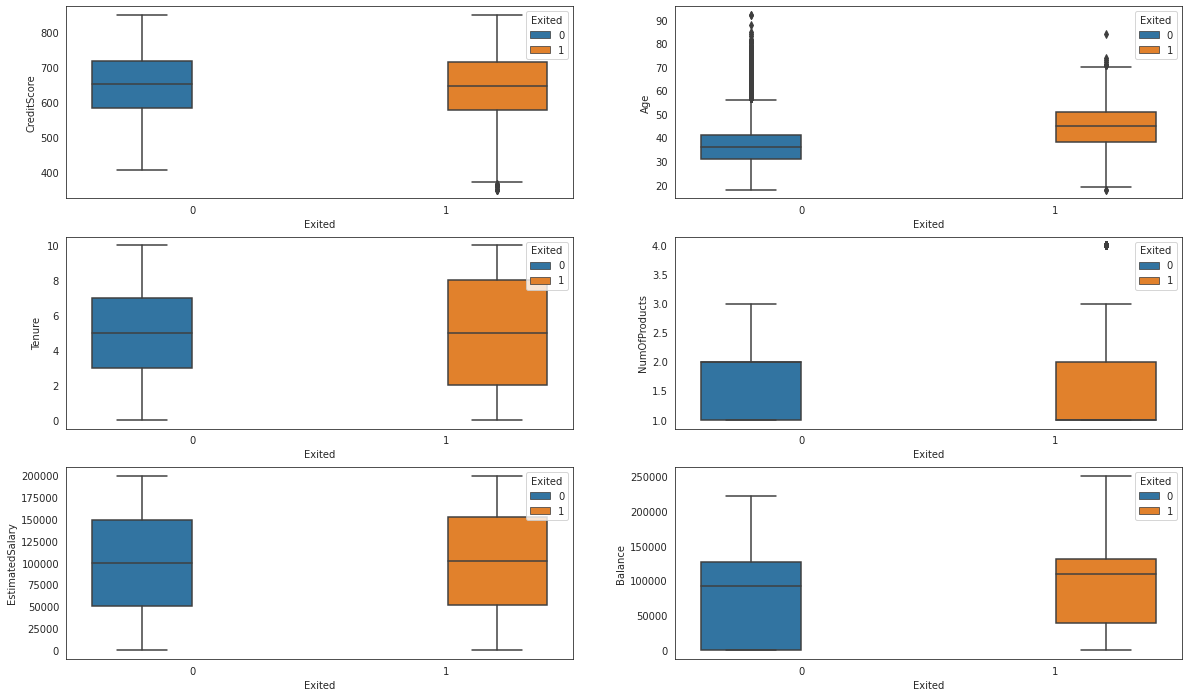

In [23]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])


Exited status has higher age and higher balance. Prodyct or estimated salary doesn't look to play a role.

# 4. Distinguish the feature and target set and divide the data set into training and test sets (5 points)


In [24]:
X=df.drop('Exited',axis=1)
y=df['Exited']


In [25]:
#One hot encoding to convert cat variables to numeric 
geography=pd.get_dummies(X['Geography'])
geography

,France,Germany,Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


In [26]:
gender=pd.get_dummies(X['Gender'])
gender

,Female,Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,1,0
9998,0,1


In [27]:
X=pd.concat([X,geography,gender],axis=1)
X=X.drop(['Geography','Gender'],axis=1)
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain,Female,Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,0,1,0,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 13) (2000, 13) (8000,) (2000,)


# 5. Normalize the train and test data (10points)


Feature scaling is done to avoid the dominance of one feature over the other and is useful in avoiding the prediction results.

In [29]:
#X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 6. Initialize & build the model. Identify the points of improvement and implement the same. (20)


To make a better prediction, The optimum results depends on factors including the number of hidden layers, the number of hidden neurons per each hidden layer, the learning rate, and a regularization parameter,...
Here in 4 models we try diferent number of neurons, different number of hidden layers and different acivation function. 

## model1 : the base model with 64-32-1 topology and relu/tanh/sigmoid activation

In [30]:
model1=Sequential()
#input_dim refers to the number of input/independent features.
#activation_function: Activation function decides whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.
#Two types of activation functions: RELU and SIGMOID are used to build a model. (Sigmoid for binary classifier)
model1.add(Dense(64, input_shape = (13,), activation = 'relu')) #hidden layer
model1.add(Dense(32, activation = 'tanh')) #idden layer
model1.add(Dense(1, activation = 'sigmoid')) #output layer
#optimizer for minimising th cost function with learning rate
sgd = optimizers.Adam(lr = 0.001)
#compile the model
model1.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model1.summary()
history1=model1.fit(X_train, y_train.values, batch_size = 700, epochs = 100, verbose = 1,validation_split=0.33)
#make prediction for model evaluation
y_pred = model1.predict_classes(X_test, batch_size=200, verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 1s 50ms/step - loss: 0.7977 - accuracy: 0.4459 - val_loss: 0.5993 - val_accuracy: 0.6956
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5708 - accuracy: 0.7320 - val_loss: 0.5120 - val_accuracy: 0.7948
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.5104 - accuracy: 0.7954 - val_lo

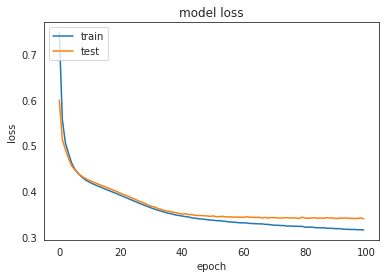

loss: 0.7816983


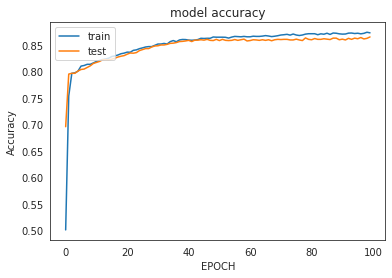

accuarcy: 0.8565


In [31]:
#plot metrics for identifying the loss and accuracy 
#loss vs value loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
bce = tf.keras.losses.BinaryCrossentropy()
y_pred_cl = model1.predict(X_test)
print ('loss:',bce(y_test, y_pred_cl).numpy())

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_test,y_pred)
print('accuarcy:',m.result().numpy())

## model2 : the base model with 64-32-1 topology and relu/relu/sigmoid activation

In [32]:
model2=Sequential()
#input_dim refers to the number of input/independent features.
#activation_function: Activation function decides whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.
#Two types of activation functions: RELU and SIGMOID are used to build a model. (Sigmoid for binary classifier)
model2.add(Dense(64, input_shape = (13,), activation = 'relu')) #hidden layer
model2.add(Dense(32, activation = 'relu')) #idden layer
model2.add(Dense(1, activation = 'sigmoid')) #output layer
#optimizer for minimising th cost function with learning rate
sgd = optimizers.Adam(lr = 0.001)
model2.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model2.summary()
history2=model2.fit(X_train, y_train.values, batch_size = 700, epochs = 100, verbose = 1,validation_split=0.33)
y_pred = model2.predict_classes(X_test, batch_size=200, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,009
Trainable params: 3,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 1s 22ms/step - loss: 0.6351 - accuracy: 0.7044 - val_loss: 0.5596 - val_accuracy: 0.7955
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5409 - accuracy: 0.7943 - val_loss: 0.5111 - val_accuracy: 0.7963
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4992 - accuracy: 0.7999 - val_

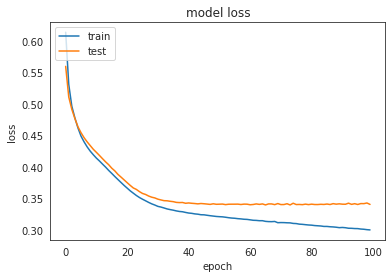

loss: 0.8174319


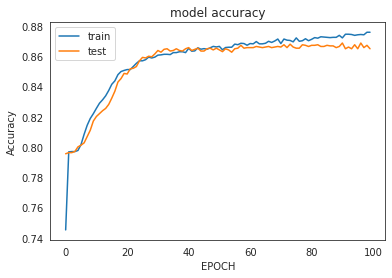

accuarcy: 0.8535


In [33]:
#loss vs value loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
bce = tf.keras.losses.BinaryCrossentropy()
y_pred_cl = model2.predict(X_test)
print ('loss:',bce(y_test, y_pred_cl).numpy())

# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_test,y_pred)
print('accuarcy:',m.result().numpy())

## model3 : the base model with 128-64-1 topology and relu/relu/sigmoid activation

In [34]:
model3=Sequential()
#input_dim refers to the number of input/independent features.
#activation_function: Activation function decides whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.
#Two types of activation functions: RELU and SIGMOID are used to build a model. (Sigmoid for binary classifier)
model3.add(Dense(128, input_shape = (13,), activation = 'relu')) #hidden layer
model3.add(Dense(64, activation = 'relu')) #idden layer
model3.add(Dense(1, activation = 'sigmoid')) #output layer
#optimizer for minimising th cost function with learning rate
sgd = optimizers.Adam(lr = 0.001)
model3.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model3.summary()
history3=model3.fit(X_train, y_train.values, batch_size = 700, epochs = 100, verbose = 1,validation_split=0.33)
y_pred = model3.predict_classes(X_test, batch_size=200, verbose=1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 1s 23ms/step - loss: 0.5828 - accuracy: 0.7715 - val_loss: 0.5066 - val_accuracy: 0.7963
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.4957 - accuracy: 0.7975 - val_loss: 0.4760 - val_accuracy: 0.7963
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.4732 - accuracy: 0.7907 - va

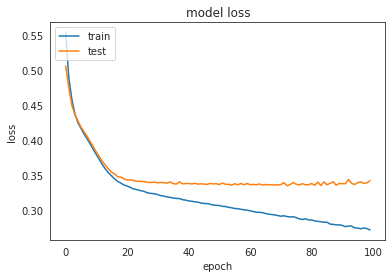

loss: 0.8635131


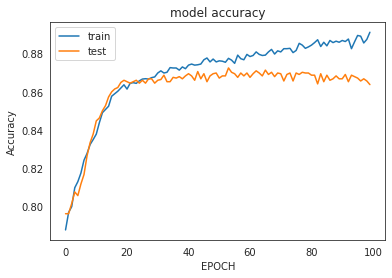

accuarcy: 0.8555


In [35]:
#loss vs value loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
bce = tf.keras.losses.BinaryCrossentropy()
y_pred_cl = model3.predict(X_test)
print ('loss:',bce(y_test, y_pred_cl).numpy())

# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_test,y_pred)
print('accuarcy:',m.result().numpy())

## model4 : the base model with 64-1 topology and relu/sigmoid activation

In [36]:
model4=Sequential()
#input_dim refers to the number of input/independent features.
#activation_function: Activation function decides whether a neuron should be activated or not by calculating the weighted sum and further adding bias with it. The purpose of the activation function is to introduce non-linearity into the output of a neuron.
#Two types of activation functions: RELU and SIGMOID are used to build a model. (Sigmoid for binary classifier)
model4.add(Dense(64, input_shape = (13,), activation = 'relu')) #hidden layer
model4.add(Dense(1, activation = 'sigmoid')) #output layer
#optimizer for minimising th cost function with learning rate
sgd = optimizers.Adam(lr = 0.001)
model4.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics=['accuracy'])
model4.summary()
history4=model4.fit(X_train, y_train.values, batch_size = 700, epochs = 100, verbose = 1,validation_split=0.33)
y_pred = model4.predict_classes(X_test, batch_size=200, verbose=1)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 21ms/step - loss: 0.7512 - accuracy: 0.4615 - val_loss: 0.6896 - val_accuracy: 0.5627
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6728 - accuracy: 0.5981 - val_loss: 0.6233 - val_accuracy: 0.7251
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.6082 - accuracy: 0.7457 - val_loss: 0.5743 - val_accuracy: 0.7815
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.5632 - accuracy: 0.7887 - v

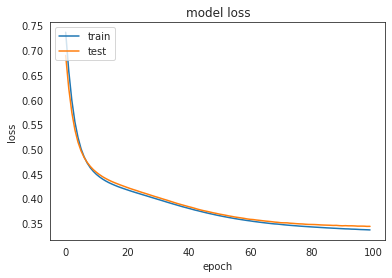

loss: 0.7184263


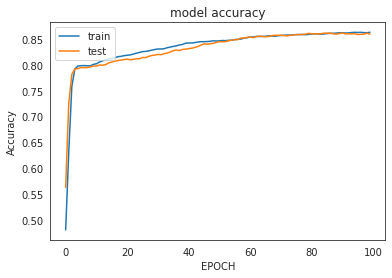

accuarcy: 0.852


In [37]:
#loss vs value loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
bce = tf.keras.losses.BinaryCrossentropy()
y_pred_cl = model4.predict(X_test)
print ('loss:',bce(y_test, y_pred_cl).numpy())

# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_test,y_pred)
print('accuarcy:',m.result().numpy())

Last model made better accuracy as 0.86 and less loss which gives higher recall in later observations

# 7. Predict the results using 0.5 as a threshold (10points)


In [38]:
model=model4
results = model.evaluate(X_test, y_test.values)


63/63 [==============================] - 0s 2ms/step - loss: 0.3587 - accuracy: 0.8520


In [39]:
print(model.metrics_names)
print('test data:',results)   


['loss', 'accuracy']
test data: [0.3587339222431183, 0.8519999980926514]


In [40]:
#the default is 0.5 for y_pred<0.5 is 0 and y_pred>0.5=1
Y_pred= model.predict_classes(X_test, batch_size=200, verbose=0)
Y_pred[1:20]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [41]:
#or using prediction variable
#y_pred = model1.predict(X_test)
#y_pred[y_pred>0.5]=1
#y_pred[y_pred<0.5]=0
#y_pred[1:20]

In [42]:
#we predict the accuracy using the threshhold as 1
m = tf.keras.metrics.BinaryAccuracy(threshold=0.5)
m.update_state(y_test,Y_pred)
m.result().numpy()

0.852

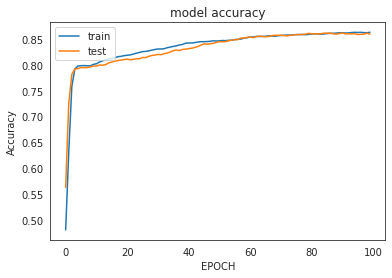

In [43]:
#Accuracy vs Value Accuracy
history=history4
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('EPOCH')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

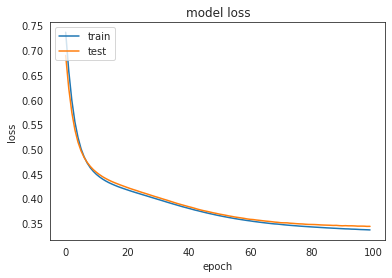

loss: 0.7184263


In [44]:

#loss vs value loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
bce = tf.keras.losses.BinaryCrossentropy()
y_pred_cl = model.predict(X_test)
print ('loss:',bce(y_test, y_pred_cl).numpy())

# 8. Print the Accuracy score and confusion matrix (5 points)


In [45]:
print('Accuracy Model (test): '+ str(model.evaluate(X_test,y_test.values)[1]))
print('Accuracy Model (train): '+ str(model.evaluate(X_train,y_train.values)[1]))

print('Recall_score: ' + str(recall_score(y_test.values,Y_pred)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred)))
print('F-score: ' + str(f1_score(y_test.values,Y_pred)))
confusion_matrix(y_test.values, Y_pred)

63/63 [==============================] - 0s 1ms/step - loss: 0.3587 - accuracy: 0.8520
Accuracy Model (test): 0.8519999980926514
250/250 [==============================] - 1s 2ms/step - loss: 0.3385 - accuracy: 0.8625
Accuracy Model (train): 0.862500011920929
Recall_score: 0.4306569343065693
Precision_score: 0.7405857740585774
F-score: 0.5446153846153846


array([[1527,   62],
       [ 234,  177]])

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test.astype('int'), Y_pred.astype('int')))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1589
           1       0.74      0.43      0.54       411

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [47]:
tn,fp,fn,tp = confusion_matrix(y_test.astype('int'), Y_pred.astype('int')).ravel()
print('tn=',tn)
print('fp=',fp)
print('fn=',fn)
print('tp=',tp)

########
#tn  fp#
#fn  tp#
########

tn= 1527
fp= 62
fn= 234
tp= 177


Confusion matrix and Plotting: The confusion matrix is a two-dimensional array comparing predicted category labels to the true label. For binary classification, these are the True Positive, True Negative, False Positive, and False Negative categories.

Confusion matrix meaning: 

True Negative (observed=0,predicted=0):
it was predicted as not churn (exited 0) and the client did not churn (exit status =0)=1527

False Positive (observed=0,predicted=1):
it was predicted as churn (exited 1) and the client did not churn (exit status =0)=62

False Negative (observed=1,predicted=0):
it was predicted as not churn (exited 0) and the client did churn (exit status =1)=234

True Positive (observed=1,predicted=1):
it was predicted as churn (exited 1) and the client did churn (exit status =1)=177

Recall ratio of the model is (TP/(TP+FN)))=0.43 and the precision of the model is TP/(TP+FP)=0.74.  It is better to increase recall means predict more accuratly the clients who really churn but are not predicted by the model. We have just 20% churn from all the data so any value higher than this is an improvement. The precision needs to be high enough so banck doesn't wase the resources on false positive detection of the exited clients.

The model has high accuarcy but recall is around 47% means still misses about half of those who already churning, and mor edata is needed to train. 